In [70]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import datetime

DATA_DIR = Path('../data/')
pd.set_option('max_columns', 999)

# Loading data

In [30]:
# Extract list of dates, list of calendar filepaths, list of listing filepaths
dates = [re.findall(r'_20(\d{2})-(\d{2})-(\d{2}).*', cal_file.stem)[0] for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
cal_files = [cal_file for cal_file in DATA_DIR.iterdir() if 'calendar' in cal_file.stem]
# listing_files = [listing_file for listing_file in DATA_DIR.iterdir() if 'listing' in listing_file.stem]

In [31]:
dates

[('16', '04', '03'),
 ('16', '05', '02'),
 ('16', '06', '02'),
 ('16', '07', '02'),
 ('16', '08', '02'),
 ('16', '09', '02'),
 ('16', '10', '01'),
 ('16', '11', '02'),
 ('16', '12', '03'),
 ('17', '01', '01'),
 ('17', '02', '02'),
 ('17', '03', '02'),
 ('17', '04', '02'),
 ('17', '05', '02'),
 ('17', '06', '02'),
 ('17', '07', '02'),
 ('17', '08', '02'),
 ('17', '09', '02'),
 ('17', '10', '02'),
 ('17', '11', '01'),
 ('17', '12', '02'),
 ('18', '01', '10'),
 ('18', '02', '02'),
 ('18', '03', '04'),
 ('18', '04', '06'),
 ('18', '05', '09')]

In [3]:
# # Read in data for each month from 04/2016 to 05/2018 (runtime: 2m)
# # for date, cal, listing in zip(dates, cal_files, listing_files):
# for date, cal in zip(dates, cal_files):
#     # For April 2016, 'cal_1604' and 'listing_1604'
# #     exec("listing_" + str(date[0]) + str(date[1]) + " = pd.read_csv(listing, compression='gzip')")
#     exec("cal_" + str(date[0]) + str(date[1]) + " = pd.read_csv(cal, compression='gzip')")

In [4]:
# # Create list of all calendars and listings

# listings, cals = [], []
# # [exec("listings.append(listing_" + str(date[0]) + str(date[1]) + ")") for date in dates]
# [exec("cals.append(cal_" + str(date[0]) + str(date[1]) + ")") for date in dates]

In [5]:
# listing_1604.head()

In [6]:
# cal_1604.head()

# Preprocessing

In [7]:
# # Convert calendar date to datetime, and remove $ from price (runtime: 3m)
# for i in range(len(cals)):
#     cals[i]['date'] = pd.to_datetime(cals[i]['date'])
#     cals[i]['price'] = (
#         cals[i]
#         .loc[:, 'price']
#         .str.extract(r'\$(.*)', expand=False)
#         .str.replace(r',', '')
#         .astype(np.float_)
#     )

# Pipeline for extracting data for events

In [32]:
EVENT_START = pd.Timestamp(2017, 11, 1)
EVENT_END = pd.Timestamp(2017, 11, 15)

In [26]:
final_cal = None
for date, filepath in zip(dates[8:20], cal_files[8:20]):
    data = pd.read_csv(filepath, compression='gzip')
    data['date'] = pd.to_datetime(data['date'])
    data['price'] = (
        data
        .loc[:, 'price']
        .str.extract(r'\$(.*)', expand=False)
        .str.replace(r',', '')
        .astype(np.float_)
    )
    subset = data[(data['date'] >= EVENT_START) & (data['date'] <= EVENT_END)]
    subset['scraped'] = pd.Timestamp(2000 + int(date[0]), int(date[1]), int(date[2]))
    if final_cal is None:
        final_cal = subset
    else:
        final_cal = pd.concat([final_cal, subset])

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
def get_cal_data(event_start, event_end, dates, cal_files):
    final_cal = None
    for date, filepath in zip(dates, cal_files):
        data = pd.read_csv(filepath, compression='gzip')
        data['date'] = pd.to_datetime(data['date'])
        data['price'] = (
            data
            .loc[:, 'price']
            .str.extract(r'\$(.*)', expand=False)
            .str.replace(r',', '')
            .astype(np.float_)
        )
        subset = data[(data['date'] >= EVENT_START) & (data['date'] <= EVENT_END)]
        subset['scraped'] = pd.Timestamp(2000 + int(date[0]), int(date[1]), int(date[2]))
        if final_cal is None:
            final_cal = subset
        else:
            final_cal = pd.concat([final_cal, subset])
    
    del data
    return final_cal

In [40]:
final_cal[final_cal['scraped'] == pd.Timestamp(2016, 12, 3)].isnull().mean()

listing_id    0.000000
date          0.000000
available     0.000000
price         0.633583
scraped       0.000000
dtype: float64

In [35]:
final_cal.shape

(1592835, 5)

In [85]:
medians = final_cal.groupby(['date', 'scraped']).median().drop(columns='listing_id').reset_index()
medians['conference'] = pd.cut(medians['date'], 
                               bins=[pd.Timestamp(2017, 11, 1), pd.Timestamp(2017, 11, 3), 
                                     pd.Timestamp(2017, 11, 9), pd.Timestamp(2017, 11, 15)], 
                               right=True,
                               labels=['Before', 'During', 'After'])

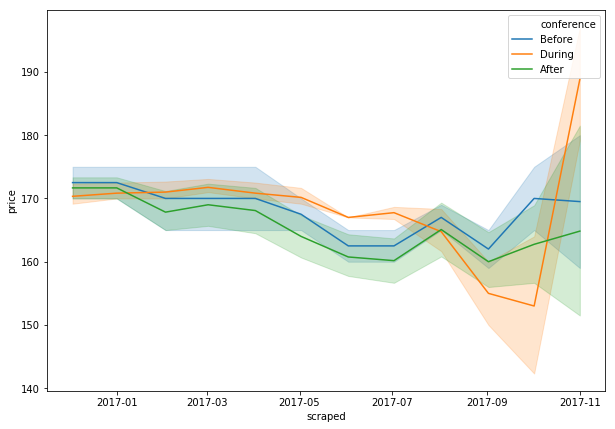

In [89]:
plt.figure(figsize=(10, 7))
sns.lineplot(data=medians.reset_index(), x='scraped', y='price', hue='conference');

In [50]:
plt.plot(medians['2017-11-01'])

TypeError: '('2017-11-01', slice(None, None, None))' is an invalid key

# Neighborhods

In [75]:
neighborhoods = gpd.read_file('../data/neighbourhoods.geojson')

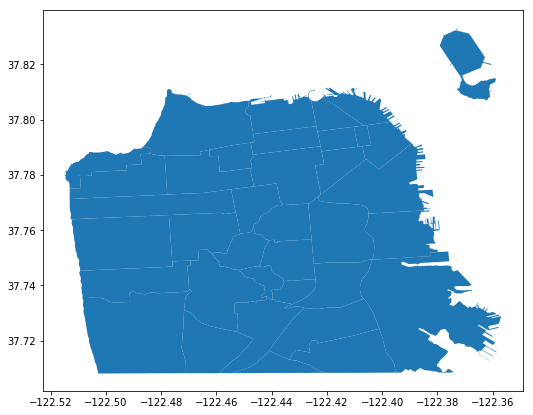

In [79]:
fig, ax = plt.subplots(figsize=(10, 7))
neighborhoods.plot(ax=ax)

In [80]:
neighborhoods

,neighbourhood,neighbourhood_group,geometry
0,Seacliff,None,"(POLYGON ((-122.484089 37.78791, -122.484346 3..."
1,Haight Ashbury,None,"(POLYGON ((-122.435964 37.769038, -122.436851 ..."
2,Outer Mission,None,"(POLYGON ((-122.454284 37.708222, -122.45456 3..."
3,Downtown/Civic Center,None,"(POLYGON ((-122.408912 37.790132, -122.408797 ..."
4,Diamond Heights,None,"(POLYGON ((-122.435527 37.74146, -122.435632 3..."
5,Lakeshore,None,"(POLYGON ((-122.471051 37.708198, -122.472829 ..."
6,Russian Hill,None,"(POLYGON ((-122.420952 37.808967, -122.420614 ..."
7,Noe Valley,None,"(POLYGON ((-122.425578 37.756617, -122.424949 ..."
8,Inner Sunset,None,"(POLYGON ((-122.451436 37.758735, -122.451399 ..."
9,Treasure Island/YBI,None,"(POLYGON ((-122.373133 37.832253, -122.368622 ..."
